# 📜 문서 타입 분류 대회

> - kimkihong / helpotcreator@gmail.com / Upstage AI Lab 3기
> - 2024.07.30.화 10:00 ~ 2024.08.11.일 19:00

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import os 
from glob import glob 
from PIL import Image
import albumentations as A
from albumentations import ImageOnlyTransform
from augraphy import *
from tqdm import tqdm
import platform

os_name = platform.system()
if os_name == 'Windows':
    PRE_PATH = ''
elif os_name == 'Linux':
    PRE_PATH = '/kkh/'
elif os_name == 'Darwin': # 맥
    PRE_PATH = '/kkh/'

TRAIN_KR_IMAGE_PATH = PRE_PATH + 'data/train_kr'
TRAIN_KR_AUG_IMAGE_PATH = PRE_PATH + 'data/train_kr_aug' # 증강한 이미지들을 담을 폴더명 미리 지정
META_KR_CSV_PATH = PRE_PATH + 'data/meta_kr.csv'
META_KR_DF = pd.read_csv(META_KR_CSV_PATH)
TRAIN_KR_CSV_PATH = PRE_PATH + 'data/train_kr.csv'
TRAIN_KR_DF = pd.read_csv(TRAIN_KR_CSV_PATH)

In [2]:
import torch
print(torch.cuda.is_available())

True


## 증강한 이미지들을 담을 폴더를 생성

In [3]:
# train_kr_aug_image_path 폴더 생성
def create_directory_with_backup(path):
    try:
        if os.path.exists(path):
            backup_path = path + '_backup'
            os.rename(path, backup_path)
            print(f"Existing folder renamed to: {backup_path}")
        os.makedirs(path)
        print(f"Folder created: {path}")
    except Exception as e:
        print(f"An error occurred: {e}")
create_directory_with_backup(TRAIN_KR_AUG_IMAGE_PATH)

Existing folder renamed to: /kkh/data/train_kr_aug_backup
Folder created: /kkh/data/train_kr_aug


## albumentations 세팅

In [4]:
# 회전 변환 + 수평 뒤집기
hf_rotate_000 = A.Compose([A.HorizontalFlip(p=1)])
hf_rotate_045 = A.Compose([A.HorizontalFlip(p=1), A.Rotate(limit=(45, 45), p=1)])
hf_rotate_090 = A.Compose([A.HorizontalFlip(p=1), A.Rotate(limit=(90, 90), p=1)])
hf_rotate_135 = A.Compose([A.HorizontalFlip(p=1), A.Rotate(limit=(135, 135), p=1)])
hf_rotate_180 = A.Compose([A.HorizontalFlip(p=1), A.Rotate(limit=(180, 180), p=1)])
hf_rotate_225 = A.Compose([A.HorizontalFlip(p=1), A.Rotate(limit=(225, 225), p=1)])
hf_rotate_270 = A.Compose([A.HorizontalFlip(p=1), A.Rotate(limit=(270, 270), p=1)])
hf_rotate_315 = A.Compose([A.HorizontalFlip(p=1), A.Rotate(limit=(315, 315), p=1)])

# 회전 변환
rotate_045 = A.Compose([A.Rotate(limit=(45, 45), p=1)])
rotate_090 = A.Compose([A.Rotate(limit=(90, 90), p=1)])
rotate_135 = A.Compose([A.Rotate(limit=(135, 135), p=1)])
rotate_180 = A.Compose([A.Rotate(limit=(180, 180), p=1)])
rotate_225 = A.Compose([A.Rotate(limit=(225, 225), p=1)])
rotate_270 = A.Compose([A.Rotate(limit=(270, 270), p=1)])
rotate_315 = A.Compose([A.Rotate(limit=(315, 315), p=1)])

# 여러 이미지 변환을 정의한 리스트입니다. 각 변환은 튜플로 되어 있으며, 튜플의 첫 번째 요소는 변환의 접두사(prefix)이고, 두 번째 요소는 변환 객체입니다.
base_aug_types = [
    (f"hf_r000_", hf_rotate_000),
    (f"hf_r045_", hf_rotate_045),
    (f"hf_r090_", hf_rotate_090),
    (f"hf_r135_", hf_rotate_135),
    (f"hf_r180_", hf_rotate_180),
    (f"hf_r225_", hf_rotate_225),
    (f"hf_r270_", hf_rotate_270),
    (f"hf_r315_", hf_rotate_315),
    (f"r045_", rotate_045),
    (f"r090_", rotate_090),
    (f"r135_", rotate_135),
    (f"r180_", rotate_180),
    (f"r225_", rotate_225),
    (f"r270_", rotate_270),
    (f"r315_", rotate_315) 
]

## augraphy의 VoronoiTessellation 필터 함수 선언

In [5]:
from augraphy import *
def voronoi_image(image_np):
    paper_phase = [Brightness(brightness_range=(0.8, 1.2), min_brightness_value=(120, 150), p=0)]
    post_phase = [
        BrightnessTexturize(texturize_range=(0.9, 0.95), deviation=(0.3), p=1),  # 밝기 변화 줄임
        VoronoiTessellation(mult_range=(200, 300), num_cells_range=(300, 340), p=1)  # 패턴이 덜 보이도록 조정
    ]
    pipeline = AugraphyPipeline(
        ink_phase=[],
        paper_phase=paper_phase,
        post_phase=post_phase
    )
    transformed_image = pipeline(image_np)
    return transformed_image

# 이미지를 로드하고 넘파이 배열로 변환
# image_path = 'data/train_kr/0d6a14437ad1a20e_통원진료 확인서.jpg'
# original_image = Image.open(image_path)
# image_np = np.array(original_image)
# augmented_image_np = augment_image(image_np)
# augmented_image = Image.fromarray(augmented_image_np)

## albumentations 이용해서, 이미지 증강 진행

Image augmentation:   6%|▋         | 100/1570 [07:21<1:47:24,  4.38s/it]

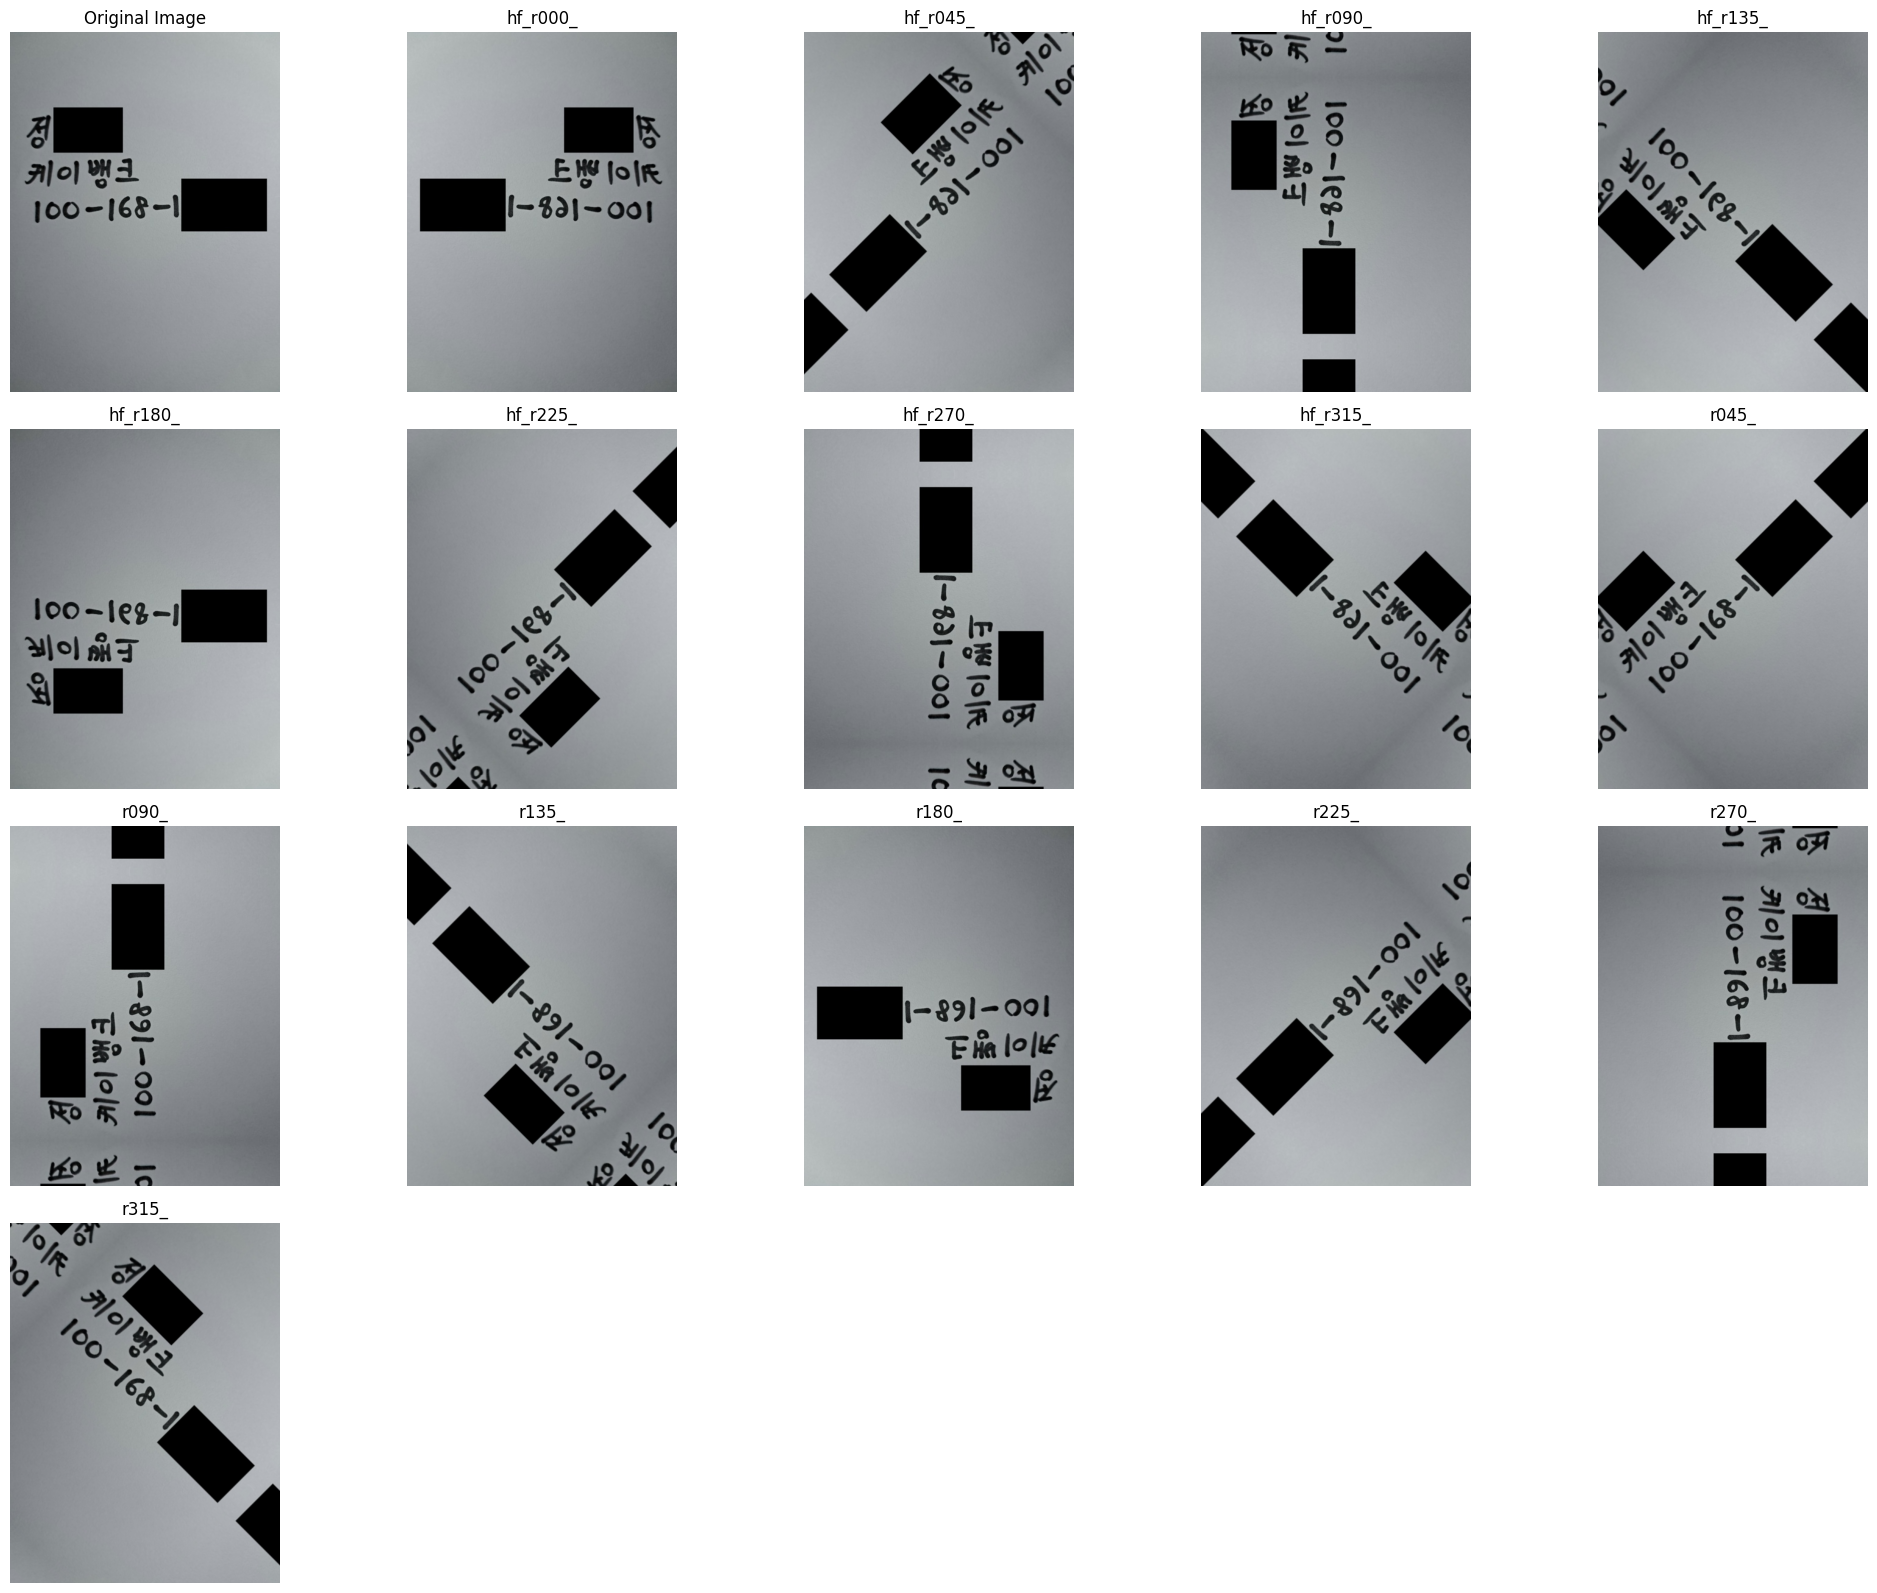

Image augmentation: 100%|██████████| 1570/1570 [2:27:27<00:00,  5.64s/it] 


In [6]:
# 빈 리스트를 초기화합니다. 변환된 이미지의 ID와 타겟 정보를 저장할 것입니다.
ids = []
targets = []

# `train_kr_df` DataFrame의 각 행에 대해 반복합니다.
# `itertuples()`는 DataFrame을 튜플 형태로 반복할 수 있게 해줍니다.
for index, ID, target in tqdm(TRAIN_KR_DF.itertuples(), total=TRAIN_KR_DF.shape[0], desc='Image augmentation'):
    image_path = os.path.join(TRAIN_KR_IMAGE_PATH, ID)
    image = np.array(Image.open(image_path))
    
    # `base_aug_types`에 정의된 각 변환에 대해 반복합니다.
    for prefix, aug_function in base_aug_types:
        # 변환 함수를 사용하여 이미지를 변환합니다.
        transformed_image = aug_function(image=image)['image']
        transformed_image = voronoi_image(transformed_image)
        new_ID = prefix + ID
        ids.append(new_ID)
        targets.append(target)
        Image.fromarray(transformed_image).save(os.path.join(TRAIN_KR_AUG_IMAGE_PATH, new_ID))

    # 인덱스가 100인 경우, 원본 이미지와 변환된 이미지들을 시각적으로 표시합니다.
    if index == 100:
        # 원본 이미지 표시
        plt.figure(figsize=(20, 20))
        plt.subplot(5, 5, 1)
        plt.title('Original Image')
        plt.imshow(image)
        plt.axis('off')
        
        # 변환된 이미지들 표시
        for i, (prefix, aug_function) in enumerate(base_aug_types):
            # 변환 함수를 사용하여 이미지를 변환합니다.
            transformed_image = aug_function(image=image)['image']
            
            plt.subplot(5, 5, i + 2)
            plt.title(prefix)
            plt.imshow(transformed_image)
            plt.axis('off')
        plt.tight_layout()
        plt.show()

# 변환된 이미지의 ID와 타겟 정보를 담은 DataFrame을 생성합니다.
aug_data = {
    'ID': ids,
    'target': targets
}
aug_data = pd.DataFrame(aug_data)

## 증강한 폴더에 원본 이미지도 복사해서 넣는다.

In [14]:
import shutil

def copy_files(source_dir, dest_dir):
    # 소스 폴더가 존재하는지 확인합니다.
    if not os.path.exists(source_dir):
        print(f"Error: Source directory '{source_dir}' does not exist.")
        return
    try:
        # 소스 디렉토리의 모든 파일을 반복합니다.
        for filename in os.listdir(source_dir):
            source_file = os.path.join(source_dir, filename)
            dest_file = os.path.join(dest_dir, filename)
            
            # 파일을 목적지 폴더로 복사합니다.
            shutil.copy2(source_file, dest_file)
        print("All files copied successfully.")
    except Exception as e:
        print(f"An error occurred: {e}")

copy_files(TRAIN_KR_IMAGE_PATH, TRAIN_KR_AUG_IMAGE_PATH)

All files copied successfully.


## 엑셀 파일에 증강한 내용도 넣는다.

In [15]:
# 원본 DataFrame `TRAIN_KR_DF`와 증강된 데이터 `aug_data`를 결합하여 새로운 DataFrame `df`를 만듭니다.
df = pd.concat([TRAIN_KR_DF, aug_data])

# 저장할 파일 경로 정의
TRAIN_KR_AUG_CSV_PATH = PRE_PATH + 'data/train_kr_aug.csv'

if os.path.exists(TRAIN_KR_AUG_CSV_PATH):
    backup_path = TRAIN_KR_AUG_CSV_PATH.replace('.csv', '_backup.csv')
    os.rename(TRAIN_KR_AUG_CSV_PATH, backup_path)

df.to_csv(TRAIN_KR_AUG_CSV_PATH, index=False)

## 원본과 증강까지한 내용들의 개수를 비교한다.

- /kkh/data/train_kr          원본 이미지 폴더
- /kkh/data/train_kr.csv      원본 엑셀 파일
- /kkh/data/train_kr_aug      증강 + 원본 이미지 폴더
- /kkh/data/train_kr_aug.csv  증강 + 원본 엑셀 파일

In [16]:
# 폴더 내 이미지 개수 확인(ls -1 . | wc -l)

# 원본만
image_count = len([f for f in os.listdir(TRAIN_KR_IMAGE_PATH) if os.path.isfile(os.path.join(TRAIN_KR_IMAGE_PATH, f))])
print(f"{TRAIN_KR_IMAGE_PATH} contains {image_count} images.")
# CSV 파일 내 이미지 개수 확인
df = pd.read_csv(TRAIN_KR_CSV_PATH)
csv_image_count = df.shape[0]
print(f"{TRAIN_KR_CSV_PATH} contains {csv_image_count} image records.")

print(f"=================================")

# 증강 + 원본
image_count = len([f for f in os.listdir(TRAIN_KR_AUG_IMAGE_PATH) if os.path.isfile(os.path.join(TRAIN_KR_AUG_IMAGE_PATH, f))])
print(f"{TRAIN_KR_AUG_IMAGE_PATH} contains {image_count} images.")
# CSV 파일 내 이미지 개수 확인
df = pd.read_csv(TRAIN_KR_AUG_CSV_PATH)
csv_image_count = df.shape[0]
print(f"{TRAIN_KR_AUG_CSV_PATH} contains {csv_image_count} image records.")

/kkh/data/train_kr contains 1570 images.
/kkh/data/train_kr.csv contains 1570 image records.
/kkh/data/train_kr_aug contains 25120 images.
/kkh/data/train_kr_aug.csv contains 25120 image records.


## 이상치 데이터들 정제한다.

In [17]:
# CSV 파일을 읽어옵니다.
df = pd.read_csv(TRAIN_KR_AUG_CSV_PATH)

# 45f0d2dfc7e47c03_입퇴원 확인서 --> 통원진료 확인서 --> 7
# aec62dced7af97cd_입퇴원 확인서 --> 소견서 --> 14
# 8646f2c3280a4f49_통원진료 확인서 --> 입퇴원 확인서 --> 3
# 1ec14a14bbe633db_소견서 --> 통원진료 확인서 --> 7
# 7100c5c67aecadc5_입퇴원 확인서 --> 통원진료 확인서 --> 7
# c5182ab809478f12_진단서 --> 소견서 --> 14
# 38d1796b6ad99ddd_약제비 영수증 --> 진료비 납입 확인서 --> 10
# 0583254a73b48ece_약제비 영수증 --> 진료비 납입 확인서 --> 10

# 조건에 따라 타겟 값을 변경하는 함수입니다.
def update_target(row):
    if "45f0d2dfc7e47c03" in row['ID']: return 7
    elif "aec62dced7af97cd" in row['ID']: return 14
    elif "8646f2c3280a4f49" in row['ID']: return 3
    elif "1ec14a14bbe633db" in row['ID']: return 7
    elif "7100c5c67aecadc5" in row['ID']: return 7
    elif "c5182ab809478f12" in row['ID']: return 14
    elif "38d1796b6ad99ddd" in row['ID']: return 10
    elif "0583254a73b48ece" in row['ID']: return 10
    else: return row['target']

df['target'] = df.apply(update_target, axis=1)
df.to_csv(TRAIN_KR_AUG_CSV_PATH, index=False)